# Dependencies

In [ ]:
!pip install gym\[atari,accept-rom-license\]==0.21.0

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

import torch
import torch.nn as nn

import os, dill
import random, time
import gym

from collections import namedtuple, deque
from copy import deepcopy, copy
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Wrapper class for Pong

[source](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/wrappers.py)

In [ ]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

# Explore environment

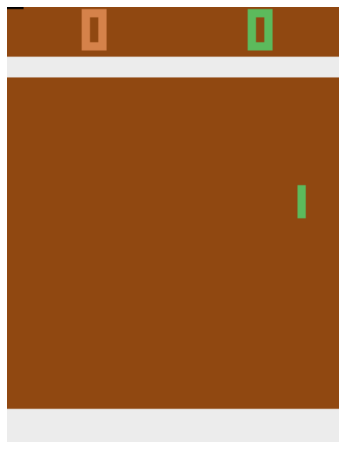

In [ ]:
env = gym.make("PongDeterministic-v4")
env = FireResetEnv(env)
state = env.reset()
plt.figure(figsize=(12,8))
plt.imshow(state)
plt.axis('off')
plt.show()

In [ ]:
print(f'Number of possible actions: {env.action_space.n}')

Number of possible actions: 6


In [ ]:
def play_one_episode():
    done = False
    s = env.reset()
    reward = 0
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        reward += r

    return reward


# Preprocessing:

1. Convert to grayscale.
2. Ressize to 75 x 80

In [ ]:
# # convert to gray scale
# def convert_to_gray(img):
#     return np.dot(img, [0.2989, 0.5870, 0.1140])

[source](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)

In [ ]:
def convert_to_gray_rescale(img):
    """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
    img = img[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    img = img[::2,::2,0] # downsample by factor of 2.
    img[img == 144] = 0 # erase background (background type 1)
    img[img == 109] = 0 # erase background (background type 2)
    img[img != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
    return img # ravel flattens an array and collapses it into a column vector

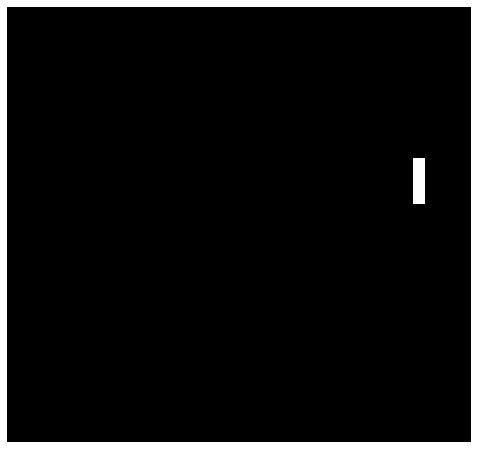

In [ ]:
state_g = convert_to_gray_rescale(state)
plt.figure(figsize=(12,8))
plt.imshow(state_g, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def normalize(img):
    return img / 255

In [ ]:
# putting everything together
def preprocess(img):
    img_g = convert_to_gray_rescale(img)
    #img_t = resize(img_g, (84, 84))
    img_n = normalize(img_g)
    return img_n

# Replay Buffer Class

In [ ]:
class ReplayBuffer(object):
    def __init__(self, env, capacity, n_frames):
        self.env = env
        self.capacity = capacity
        self.n_frames = n_frames
        self.buffer = namedtuple('Buffer', field_names=['state', 'action', 'reward', 'done','next_state'])
        self.memory = deque(maxlen=capacity)
        
    def push(self, state, action, reward, done, next_state):
        # convert (state, action, next_state, reward, done)
        self.memory.append(self.buffer(state, action, reward, done, next_state))
        
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        batch = zip(*[self.memory[i] for i in indices])
        return batch
    
    def populate(self, length):
        # populate buffer
        state_frames = deque(maxlen=self.n_frames)
        next_state_frames = deque(maxlen=self.n_frames)
        zeros = np.zeros((75,80))


        while len(self.memory) < length:
            # init frames
            for i in range(self.n_frames):
                state_frames.append(zeros)
                next_state_frames.append(zeros)
            
            done = False
            s0 = self.env.reset()
            while not done:
                action = self.env.action_space.sample()
                s1, r, done, _ = self.env.step(action)

                # build input states
                s0_t = preprocess(s0) # (84, 84)
                state_frames.append(s0_t) # stack of 4 (84,84)
                s1_t = preprocess(s1) # (84, 84)
                next_state_frames.append(s1_t) # stack of 4 (84,84)

                # stack 4 frames in  tensor
                input_state = np.stack(state_frames)
                input_next_state = np.stack(next_state_frames)

                # update buffer
                self.push(input_state, action, r, done, input_next_state)
                s0 = s1

                if len(self.memory) >= length:
                    break
        
    def __len__(self):
        return len(self.memory)

# Dueling D-DQN Class

In [ ]:
class QNetwork(nn.Module):
    def __init__(self,env, n_frames):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(n_frames, 32, kernel_size=8, stride=4), # input_shape: batch_size x 4 x 84 x 84 -> batch_size x 32 x 20 x 20
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        
        conv_out_shape = self._get_input_shape([4,75,80]) # replace (75,80) by your input shape

        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_shape, 512),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_shape, 512),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n)
        )
              
    def forward(self, x):
        # conv layer output
        features = self.conv(x)
        features = features.view(x.size(0), -1)

        # value stream
        values = self.value_stream(features) 

        # advantages
        advantages = self.advantage_stream(features)

        # q values
        q_values = values + (advantages - advantages.mean())

        return q_values
        
    def _get_input_shape(self, shape):
        conv_out = self.conv(torch.zeros(1, *shape))
        return int(np.prod(conv_out.size()))
        

# Agent Class

In [ ]:
class Agent():
    def __init__(self, env, buffer, epsilon, epsilon_mid, epsilon_final, decay_mid, decay_final):
        self.env = env
        self.buffer = buffer
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.epsilon_mid = epsilon_mid
        self.epsilon_final = epsilon_final
        self.decay_mid = decay_mid
        self.decay_final = decay_final
        self.state_frames = deque(maxlen=buffer.n_frames)
        self.next_state_frames = deque(maxlen=buffer.n_frames)
        self.reset_frames()
        
    def take_action(self, state):
        
        # build state frames
        state_frames = self.build_state_frames(state) # 4, 75, 80
        # which action to take ?
        action = self.get_action(state_frames)

        # take the action
        next_state, reward, done, _ = self.env.step(action)

        # build next state frames
        next_state_frames = self.build_next_state_frames(next_state)

        # push new buffer
        self.buffer.push(state_frames, action, reward, done, next_state_frames)
        
        return next_state, reward, done
        
    def get_action(self, state_frames):
        if random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.get_greedy_action(state_frames)
        return action
            
    def get_greedy_action(self, state_frames):
        with torch.no_grad():
            Q_network.eval()
            state_frames = np.expand_dims(state_frames, 0)
            state_frames = torch.FloatTensor(state_frames).to(device)
            index_action = torch.argmax(Q_network(state_frames).cpu()).item()
            Q_network.train()
        return index_action
    
    
    def learn(self, batch_size):
        # sample a batch
        batch = self.buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = [i for i in batch]

        # transform batch to tensor then to device
        states_t = torch.FloatTensor(np.array(states)).to(device)
        actions_t = torch.LongTensor(np.array(actions)).to(device)
        rewards_t = torch.FloatTensor(np.array(rewards)).to(device)
        dones_t = torch.BoolTensor(np.array(dones)).to(device)
        next_states_t = torch.FloatTensor(np.array(next_states)).to(device)

        # update rule : q(s,a) = q(s,a) + (r + gamma * max_a'_q(s',a') - q(s,a))
        # y = r + gamma * max_a'_q(s',a')
        # get q_vals target
        next_q_values = Q_target(next_states_t).detach().max(1)[0]# batch size, 1
        next_q_values[dones_t] = 0 # zero the final states
        y = rewards_t + gamma * next_q_values
        y = y.unsqueeze(1)
    
        # q_values
        q_values = Q_network(states_t).gather(1, actions_t.reshape(-1, 1))
        
        # compute loss
        loss = criterion(q_values, y)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # # Trick: gradient clipping
        for param in Q_network.parameters():
            param.grad.data.clamp_(-1, 1)

        # gradient descent
        optimizer.step()
        
        return loss.item()
         
    def reset_frames(self):
        zeros = np.zeros((75,80))
        for i in range(self.buffer.n_frames):
            self.state_frames.append(zeros)
            self.next_state_frames.append(zeros)

    def build_state_frames(self, state):
        state_t = preprocess(state)
        self.state_frames.append(state_t)
        return np.stack(self.state_frames)

    def build_next_state_frames(self, next_state):
        next_state_t = preprocess(next_state)
        self.next_state_frames.append(next_state_t)
        return np.stack(self.next_state_frames)

    def update_epsilon(self):
        e = self.epsilon 

        if e > self.epsilon_mid:
            self.epsilon = max(self.epsilon_mid, e - self.decay_mid)
        else:
            self.epsilon = max(self.epsilon_final, e - self.decay_final)
 
    def reset_epsilon(self):
        self.epsilon = self.epsilon_start

## Copy Q_net to Q_target

In [ ]:
def copy_network(Q_network, Q_target):
    Q_target.load_state_dict(Q_network.state_dict())

### Standard Weight Initialization function

In [ ]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

# Hyperparameters

In [ ]:
# Hyper params 
capacity = 40000
n_frames = 4
epsilon = 1
epsilon_mid = 0.1
epsilon_final = 0.02
initial_buffer_size = 10000
mid_exploration_frame = 1000000
final_exploration_frame = 2400000

decay_mid =  (epsilon - epsilon_mid) / mid_exploration_frame

decay_final = (epsilon_mid - epsilon_final) / (final_exploration_frame - mid_exploration_frame)


lr = 1e-4 #25e-5 # ok for pong
batch_size = 32

max_episodes = 5000
rewards_target = 19
window = 100
network_update_frequency = 4
network_sync_frequency = 1000
network_epsilon_update_frequency = 1
gamma = 0.99


# Instatiate and populate replay buffer

In [ ]:
buffer = ReplayBuffer(env, capacity, n_frames)
t0 = datetime.now()
buffer.populate(initial_buffer_size)
dt = datetime.now() - t0

print("It took :", dt, "to populate buffer of size:", len(buffer))
agent = Agent(env, buffer, epsilon, epsilon_mid, epsilon_final, decay_mid, decay_final)

It took : 0:00:08.095395 to populate buffer of size: 10000


# Save / Load functions

In [ ]:
drive_path = "/content/drive/MyDrive/PongDeterministic-v4-Dueling"

if not os.path.exists(drive_path):
    os.mkdir(drive_path)
data_names = ['models', 'mean_rewards', 'best_score', 'losses']
def save_data(episode, reward):

    print("saving to drive")

    for data in data_names:
        data_path = os.path.join(drive_path, data)
        if not os.path.exists(data_path):
            os.mkdir(data_path)

        if data == 'models':

            data_file_name = './pong_ep_{}_score_{}.pth'.format(episode, reward)
            data_file_path = os.path.join(data_path, data_file_name)

            torch.save(Q_network, data_file_path)
            print('model saved')        

        else:
            print("Saving " + data )
            data_file_name = data + f"_{episode}_{reward}.pkl"
            data_file_path = os.path.join(data_path, data_file_name)

            with open(data_file_path, 'wb') as f:
                if data == 'mean_rewards':
                    dill.dump(mean_episode_rewards, f)
                elif data == 'best_score':
                    dill.dump(best_score, f)
                elif data == 'losses':
                    dill.dump(episodes_loss, f)





In [ ]:
# 10652 _ 1873
def load_data(episode, reward):

    print("loading from drive")

    for data in data_names:
        data_path = os.path.join(drive_path, data)

        if data == 'models':
            data_file_name = f"pong_ep_{episode}_score_{reward}.pth"
            data_file_path = os.path.join(data_path, data_file_name)

            Q_network = torch.load(data_file_path, map_location=device)
            Q_target = torch.load(data_file_path, map_location=device)
            print("Models Loaded")
            print(Q_network)
        
        else:
            print("Loading " + data)
            data_file_name = data + f"_{episode}_{reward}.pkl"
            data_file_path = os.path.join(data_path, data_file_name)
            with open(data_file_path, 'rb') as f:
                if data == 'mean_rewards':
                    mean_episode_rewards = dill.load(f)
                    print("Rewards loaded, length of rewards:", len(mean_episode_rewards))
                elif data == 'best_score':
                    best_score = dill.load(f)
                    print("best score loaded:", best_score)
                elif data == 'losses':
                    episodes_loss = dill.load(f)
                    print("episodes_loss loaded, length of losses:", len(episodes_loss))

    return Q_network, Q_target, mean_episode_rewards, best_score, episodes_loss


    


In [ ]:
Q_network = QNetwork(env, n_frames)
Q_network.apply(initialize_weights)
Q_target = QNetwork(env, n_frames)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()
Q_network.to(device)
Q_target.to(device)

QNetwork(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (advantage_stream): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [ ]:
!ls /content/drive/MyDrive/PongDeterministic-v4-Dueling/models

pong_ep_0_score_-2000.pth     pong_ep_1941_score_943.pth
pong_ep_0_score_-2100.pth     pong_ep_1947_score_1026.pth
pong_ep_1000_score_-1261.pth  pong_ep_2000_score_1039.pth
pong_ep_1005_score_-1239.pth  pong_ep_2001_score_901.pth
pong_ep_1028_score_-1154.pth  pong_ep_2001_score_918.pth
pong_ep_1145_score_-1071.pth  pong_ep_2001_score_923.pth
pong_ep_1156_score_-988.pth   pong_ep_2170_score_1145.pth
pong_ep_1167_score_-902.pth   pong_ep_2183_score_1240.pth
pong_ep_1171_score_-813.pth   pong_ep_2200_score_1323.pth
pong_ep_1179_score_-715.pth   pong_ep_2385_score_-1968.pth
pong_ep_1190_score_-634.pth   pong_ep_2394_score_1406.pth
pong_ep_1200_score_-548.pth   pong_ep_2672_score_1493.pth
pong_ep_1213_score_-466.pth   pong_ep_3001_score_1039.pth
pong_ep_1224_score_-377.pth   pong_ep_4001_score_1195.pth
pong_ep_1238_score_-287.pth   pong_ep_5001_score_755.pth
pong_ep_1251_score_-200.pth   pong_ep_554_score_-1898.pth
pong_ep_1261_score_-107.pth   pong_ep_5740_score_1575.pth
pong_ep_1296_score

In [ ]:
Q_network, Q_target, mean_episode_rewards, best_score, episodes_loss = load_data(6237,1741)
Q_target.eval()
Q_network.to(device)
Q_target.to(device)

loading from drive
Models Loaded
QNetwork(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (advantage_stream): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Loading mean_rewards
Rewards loaded, length of rewards: 10475
Loading best_score
best score loaded: 17.41457638930599
Loading losses
episodes_loss loaded, length of losses: 6238


QNetwork(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (advantage_stream): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

# Training

In [ ]:
optimizer = torch.optim.Adam(Q_network.parameters(), lr=lr)
#optimizer = torch.optim.RMSprop(Q_network.parameters(), lr=lr)
criterion = nn.MSELoss()

In [ ]:
# 10652 _ 1873
#Q_network, Q_target, mean_episode_rewards, best_score, episodes_loss = load_data(10652, 1873)

In [ ]:
# training loop
t0 = datetime.now()

steps = 0

training_rewards = []
training_loss = []
mean_episode_rewards = []
episodes_reward = []
episodes_loss = []
best_score = -21
save_score_target = -19

current_episode = len(mean_episode_rewards)

# in case loading model
# steps = 4946982

# training_loss = episodes_loss
# episodes_reward = mean_episode_rewards
# save_score_target = best_score + 0.8

for i in range(max_episodes):
    
    done = False
    s0 = env.reset()
    ep_rewards = 0
    ep_losses = []
    agent.reset_frames()
    
    while not done:
        steps += 1
        
        # taking action
        s0, reward, done = agent.take_action(s0)
        ep_rewards += reward
        
        # learning
        if steps % network_update_frequency == 0:
            loss = agent.learn(batch_size)
            ep_losses.append(loss)
        
        # syncing
        if steps % network_sync_frequency == 0:
            copy_network(Q_network, Q_target)

        # update epsion
        if steps % network_epsilon_update_frequency == 0 and steps >= 50000:
            agent.update_epsilon()
        
    if done:    
        # updates after end of episode
        episodes_reward.append(ep_rewards)
        episodes_loss.append(np.mean(ep_losses))

        if len(episodes_reward) >= window:
            mean_rewards = np.mean(
                                episodes_reward[-window:])
            mean_episode_rewards.append(mean_rewards)

        else:
            mean_rewards = np.mean(
                                episodes_reward)
            mean_episode_rewards.append(mean_rewards)


        if mean_rewards > best_score:
            best_score = mean_rewards
            if mean_rewards > save_score_target:
                    save_score_target = mean_rewards + 0.8
                    save_data(i+current_episode, int(100*mean_rewards))
                    print(f'Model Saved. Total Steps: {steps}. New best score: {mean_rewards}')
                
        if i % 10 == 0:
            print("Episode {:d} Mean Rewards {:.2f} ".format(
                        i+current_episode, mean_rewards))
        if i % 100 ==0:
            print('Total steps so far:', steps)
            if agent.epsilon > agent.epsilon_final:
                print('Current epsilon:', agent.epsilon)
        
        if i % 1000 ==0 and i>0:
            print("Check point")
            save_data(i+current_episode, int(100*mean_rewards))


        if mean_rewards >= rewards_target:
            print(f"Environment Solved after {i} episodes and {steps} steps")
            break
        

            
        
        
dt = (datetime.now() - t0)
print('Script run in:', dt, 'seconds')



Episode 2001 Mean Rewards 9.30 
Total steps so far: 4950676
Episode 2011 Mean Rewards 8.05 
Episode 2021 Mean Rewards 6.97 
Episode 2031 Mean Rewards 6.78 
Episode 2041 Mean Rewards 6.45 
Episode 2051 Mean Rewards 6.14 
Episode 2061 Mean Rewards 6.56 
Episode 2071 Mean Rewards 7.24 
Episode 2081 Mean Rewards 6.85 
Episode 2091 Mean Rewards 6.17 
Episode 2101 Mean Rewards 5.69 
Total steps so far: 5236122
Episode 2111 Mean Rewards 6.53 
Episode 2121 Mean Rewards 6.88 
Episode 2131 Mean Rewards 7.59 
Episode 2141 Mean Rewards 8.40 
Episode 2151 Mean Rewards 9.71 
Episode 2161 Mean Rewards 10.75 
saving to drive
model saved
Saving mean_rewards
Saving best_score
Saving losses
Model Saved. Total Steps: 5437870. New best score: 11.4520718600649
Episode 2171 Mean Rewards 11.51 
Episode 2181 Mean Rewards 11.78 
saving to drive
model saved
Saving mean_rewards
Saving best_score
Saving losses
Model Saved. Total Steps: 5479725. New best score: 12.402210856267109
Episode 2191 Mean Rewards 12.79 
sa

In [ ]:
print("steps:", steps)

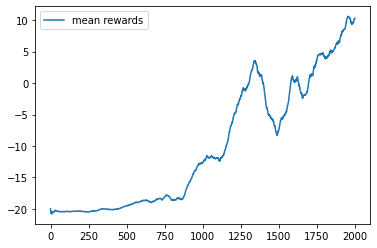

In [ ]:
#plt.plot(episodes_reward, label='episode rewards')
plt.plot(mean_episode_rewards[:2000], label='mean rewards')
plt.legend()
plt.show()


In [ ]:
max(mean_episode_rewards)

10.62

In [ ]:
mean_episode_rewards

In [ ]:
N = 2000
mean_rewards = mean_episode_rewards.copy()
while N < len(mean_episode_rewards):
    mean_rewards[N] = np.mean(mean_episode_rewards[N-window:N])
    N += 1

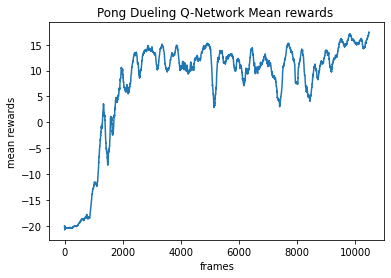

In [ ]:
plt.plot(mean_rewards)
#plt.legend()
plt.title("Pong Dueling Q-Network Mean rewards ")
plt.xlabel('frames')#, fontsize=18)
plt.ylabel('mean rewards')#, fontsize=16)
plt.show()


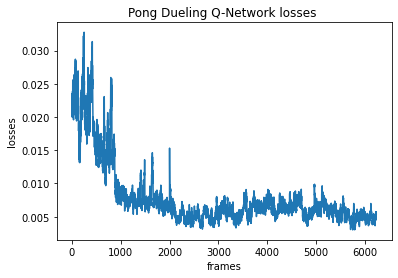

In [ ]:
#plt.plot(episodes_reward, label='episode rewards')
plt.plot(episodes_loss)
plt.title("Pong Dueling Q-Network losses ")
plt.xlabel('frames')#, fontsize=18)
plt.ylabel('losses')#, fontsize=16)
plt.show()


# Imported plots from other notebook experiments.

# Dueling DDQN Plots

In [ ]:
!ls /content/drive/MyDrive/PongDeterministic-v4-Dueling/mean_rewards/

mean_rewards_0_-2000.pkl     mean_rewards_1941_943.pkl
mean_rewards_0_-2100.pkl     mean_rewards_1947_1026.pkl
mean_rewards_1000_-1261.pkl  mean_rewards_2000_1039.pkl
mean_rewards_1005_-1239.pkl  mean_rewards_2001_901.pkl
mean_rewards_1028_-1154.pkl  mean_rewards_2001_918.pkl
mean_rewards_1145_-1071.pkl  mean_rewards_2001_923.pkl
mean_rewards_1156_-988.pkl   mean_rewards_2170_1145.pkl
mean_rewards_1167_-902.pkl   mean_rewards_2183_1240.pkl
mean_rewards_1171_-813.pkl   mean_rewards_2200_1323.pkl
mean_rewards_1179_-715.pkl   mean_rewards_2385_-1968.pkl
mean_rewards_1190_-634.pkl   mean_rewards_2394_1406.pkl
mean_rewards_1200_-548.pkl   mean_rewards_2672_1493.pkl
mean_rewards_1213_-466.pkl   mean_rewards_3001_1039.pkl
mean_rewards_1224_-377.pkl   mean_rewards_4001_1195.pkl
mean_rewards_1238_-287.pkl   mean_rewards_5001_755.pkl
mean_rewards_1251_-200.pkl   mean_rewards_554_-1898.pkl
mean_rewards_1261_-107.pkl   mean_rewards_5740_1575.pkl
mean_rewards_1296_-26.pkl    mean_rewards_5891_1660.

In [ ]:
rewards_path = "/content/drive/MyDrive/PongDeterministic-v4-Dueling/mean_rewards"
data_file_path = os.path.join(rewards_path, "mean_rewards_6237_1741.pkl")
with open(data_file_path, 'rb') as f:
        mean_episode_rewards = dill.load(f)

In [ ]:
N = 2001
window = 100
mean_episode_rewards_dueling_ddqn = mean_episode_rewards.copy()
while N < len(mean_episode_rewards_dueling_ddqn):
    mean_episode_rewards_dueling_ddqn[N] = np.mean(mean_episode_rewards[N-window:N])
    N += 1

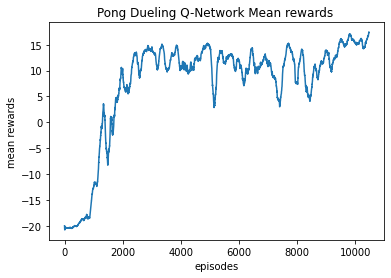

In [ ]:
plt.plot(mean_episode_rewards_dueling_ddqn)
#plt.legend()
plt.title("Pong Dueling Q-Network Mean rewards ")
plt.xlabel('episodes')#, fontsize=18)
plt.ylabel('mean rewards')#, fontsize=16)
plt.show()


# DDQN Plots

In [ ]:
!ls /content/drive/MyDrive/PongDeterministic-v4-DDQN/mean_rewards

mean_rewards_1000_-1697.pkl  mean_rewards_2011_362.pkl
mean_rewards_1023_-1652.pkl  mean_rewards_2037_447.pkl
mean_rewards_1041_-1570.pkl  mean_rewards_2259_541.pkl
mean_rewards_1053_-1477.pkl  mean_rewards_2263_625.pkl
mean_rewards_1076_-1387.pkl  mean_rewards_2267_715.pkl
mean_rewards_1120_-1305.pkl  mean_rewards_2271_810.pkl
mean_rewards_1587_-1223.pkl  mean_rewards_2285_919.pkl
mean_rewards_1600_-1135.pkl  mean_rewards_2292_1000.pkl
mean_rewards_1688_-1053.pkl  mean_rewards_2302_1092.pkl
mean_rewards_1692_-971.pkl   mean_rewards_2601_1101.pkl
mean_rewards_1696_-878.pkl   mean_rewards_2665_1180.pkl
mean_rewards_1701_-793.pkl   mean_rewards_3059_1265.pkl
mean_rewards_1706_-708.pkl   mean_rewards_3069_1354.pkl
mean_rewards_1715_-620.pkl   mean_rewards_3080_1435.pkl
mean_rewards_1722_-520.pkl   mean_rewards_3102_1518.pkl
mean_rewards_1727_-437.pkl   mean_rewards_3118_1599.pkl
mean_rewards_1733_-356.pkl   mean_rewards_3143_1680.pkl
mean_rewards_1771_-261.pkl   mean_rewards_3204_1762.pkl

In [ ]:
rewards_path = "/content/drive/MyDrive/PongDeterministic-v4-DDQN/mean_rewards"
data_file_path = os.path.join(rewards_path, "mean_rewards_3982_1843.pkl")
with open(data_file_path, 'rb') as f:
        mean_episode_rewards = dill.load(f)

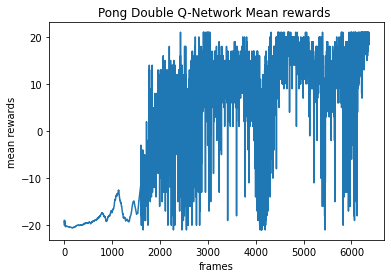

In [ ]:
plt.plot(mean_episode_rewards)
#plt.legend()
plt.title("Pong Double Q-Network Mean rewards ")
plt.xlabel('frames')#, fontsize=18)
plt.ylabel('mean rewards')#, fontsize=16)
plt.show()


In [ ]:
N = 1601
window = 100
mean_episode_rewards_ddqn = mean_episode_rewards.copy()
while N < len(mean_episode_rewards_ddqn):
    mean_episode_rewards_ddqn[N] = np.mean(mean_episode_rewards[N-window:N])
    N += 1

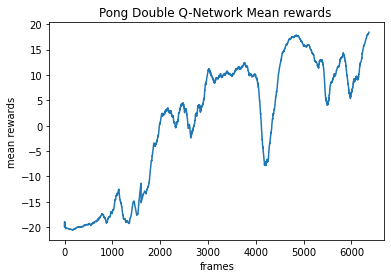

In [ ]:
plt.plot(mean_episode_rewards_ddqn)
#plt.legend()
plt.title("Pong Double Q-Network Mean rewards ")
plt.xlabel('frames')#, fontsize=18)
plt.ylabel('mean rewards')#, fontsize=16)
plt.show()


# Dueling  Plots

In [ ]:
!ls /content/drive/MyDrive/PongDeterministic-v4-Dueling-Only/mean_rewards

mean_rewards_1000_-796.pkl  mean_rewards_1551_1226.pkl
mean_rewards_1003_-770.pkl  mean_rewards_2000_858.pkl
mean_rewards_1013_-681.pkl  mean_rewards_2155_1337.pkl
mean_rewards_1025_-592.pkl  mean_rewards_2175_1431.pkl
mean_rewards_1038_-504.pkl  mean_rewards_2184_1514.pkl
mean_rewards_1062_-420.pkl  mean_rewards_2210_1595.pkl
mean_rewards_1106_-332.pkl  mean_rewards_2300_1676.pkl
mean_rewards_1219_-240.pkl  mean_rewards_2875_1757.pkl
mean_rewards_1227_-158.pkl  mean_rewards_3000_1764.pkl
mean_rewards_1237_-77.pkl   mean_rewards_3283_1838.pkl
mean_rewards_1248_9.pkl     mean_rewards_4000_1764.pkl
mean_rewards_1268_92.pkl    mean_rewards_560_-1898.pkl
mean_rewards_1285_175.pkl   mean_rewards_683_-1817.pkl
mean_rewards_1364_259.pkl   mean_rewards_775_-1736.pkl
mean_rewards_1373_356.pkl   mean_rewards_852_-1652.pkl
mean_rewards_1379_441.pkl   mean_rewards_883_-1569.pkl
mean_rewards_1384_522.pkl   mean_rewards_904_-1483.pkl
mean_rewards_1390_619.pkl   mean_rewards_922_-1378.pkl
mean_reward

In [ ]:
rewards_path = "/content/drive/MyDrive/PongDeterministic-v4-Dueling-Only/mean_rewards"
data_file_path = os.path.join(rewards_path, "mean_rewards_3283_1838.pkl")
with open(data_file_path, 'rb') as f:
        mean_episode_rewards = dill.load(f)

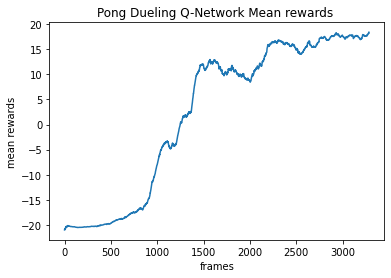

In [ ]:
plt.plot(mean_episode_rewards)
#plt.legend()
plt.title("Pong Dueling Q-Network Mean rewards ")
plt.xlabel('frames')#, fontsize=18)
plt.ylabel('mean rewards')#, fontsize=16)
plt.show()


In [ ]:
mean_episode_rewards_dueling = mean_episode_rewards

# Vanilla DQN plots

In [ ]:
!ls /content/drive/MyDrive/PongDeterministic-v4-DQN/mean_rewards

mean_rewards_0_1900.pkl      mean_rewards_2283_-22.pkl
mean_rewards_1000_-1954.pkl  mean_rewards_2604_68.pkl
mean_rewards_1054_-1898.pkl  mean_rewards_2611_171.pkl
mean_rewards_1108_-1811.pkl  mean_rewards_2622_258.pkl
mean_rewards_1132_-1727.pkl  mean_rewards_2630_352.pkl
mean_rewards_1230_-1644.pkl  mean_rewards_2683_451.pkl
mean_rewards_1247_-1563.pkl  mean_rewards_2687_553.pkl
mean_rewards_1263_-1480.pkl  mean_rewards_2692_640.pkl
mean_rewards_1328_-1394.pkl  mean_rewards_2700_722.pkl
mean_rewards_1362_-1309.pkl  mean_rewards_2709_805.pkl
mean_rewards_1380_-1224.pkl  mean_rewards_2715_886.pkl
mean_rewards_1390_-1143.pkl  mean_rewards_2722_977.pkl
mean_rewards_1981_-1061.pkl  mean_rewards_2734_1059.pkl
mean_rewards_2000_-1092.pkl  mean_rewards_3000_923.pkl
mean_rewards_2145_-978.pkl   mean_rewards_3007_1145.pkl
mean_rewards_2151_-890.pkl   mean_rewards_3018_1227.pkl
mean_rewards_2156_-797.pkl   mean_rewards_3039_1314.pkl
mean_rewards_2161_-709.pkl   mean_rewards_3657_1395.pkl
mean_r

In [ ]:
rewards_path = "/content/drive/MyDrive/PongDeterministic-v4-DQN/mean_rewards"
data_file_path = os.path.join(rewards_path, "mean_rewards_4554_1820.pkl")
with open(data_file_path, 'rb') as f:
        mean_episode_rewards = dill.load(f)

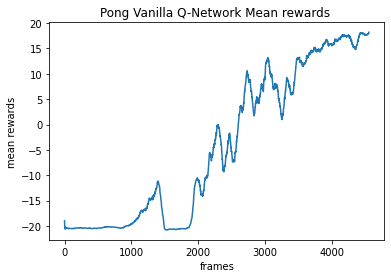

In [ ]:
plt.plot(mean_episode_rewards)
#plt.legend()
plt.title("Pong Vanilla Q-Network Mean rewards ")
plt.xlabel('frames')#, fontsize=18)
plt.ylabel('mean rewards')#, fontsize=16)
plt.show()


In [ ]:
mean_episode_rewards_dqn = mean_episode_rewards

# Ablation: All plots together

In [ ]:
N = 3500

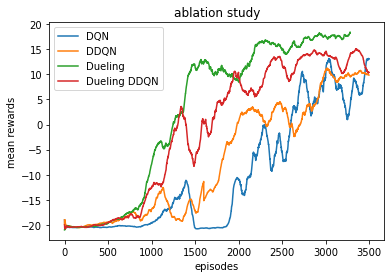

In [ ]:
plt.plot(mean_episode_rewards_dqn[:N], label="DQN")
plt.plot(mean_episode_rewards_ddqn[:N], label="DDQN")
plt.plot(mean_episode_rewards_dueling, label="Dueling")
plt.plot(mean_episode_rewards_dueling_ddqn[:N], label="Dueling DDQN")

plt.title('ablation study')

plt.legend(loc='best') 
plt.xlabel('episodes')#, fontsize=18)
plt.ylabel('mean rewards')#, fontsize=16)
plt.show()


In [ ]:
len(mean_episode_rewards_dqn)

4555